In [1]:
cd ../..

/Users/danil/Documents/github


In [2]:
import tensorflow as tf
import numpy as np
from collections import Counter
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

2023-02-22 20:20:40.336108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# convert annotations

In [3]:
with open('./clay/data/rico_to_clay/label_map.txt') as f:
    data = f.read()

labels_codes = {label.split(':')[1][1:]: int(label.split(':')[0]) for label in data.split('\n')[:-1]}

REPL_LABELS = {b'SLIDER': b'CHECK_BOX', 
               b'RADIO_BUTTON': b'SLIDER',
               b'PICTOGRAM': b'BUTTON',
               b'TEXT_INPUT': b'TEXT',
               b'LABEL': b'TEXT_INPUT'}

LABELS_TO_DROP = ['CONTAINER', 'TOOLBAR', 'BACKGROUND', 'LIST_ITEM', 'NAVIGATION_BAR', 'SPINNER', 'ADVERTISEMENT', 'DRAWER', 'CARD_VIEW', 
                  'NUMBER_STEPPER', 'PROGRESS_BAR']

LABELS_IND_TO_DROP = [labels_codes[label] for label in LABELS_TO_DROP]
LABELS_IND_TO_DROP

[21, 18, 0, 19, 17, 13, 15, 16, 20, 23, 14]

In [30]:
def filter_dataset(raw_dataset_name, output_name):
    
    raw_dataset = tf.data.TFRecordDataset(raw_dataset_name)
    
    def calc_area(result, i):
        w = result['image/object/bbox/xmax'][i] - result['image/object/bbox/xmin'][i]
        h = result['image/object/bbox/ymax'][i] - result['image/object/bbox/ymin'][i]
        curr_s = w * h
        return curr_s


    def filter_class_by_area(label, labels_codes, max_area, updated_labels, result, ind_to_use):

        if labels_codes[label] in updated_labels:
            ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == label.encode('UTF-8')]

            for ind in ind_of_switch:
                curr_s = calc_area(result, ind)
                if curr_s > max_area:
                    ind_to_use.remove(ind)

        return ind_to_use


    with tf.io.TFRecordWriter(output_name) as writer:
        #for ind_, raw_record in tqdm(enumerate(raw_dataset.take(44000)), total = 44000):
        for ind_, raw_record in enumerate(raw_dataset):

            if ind_ in [28930, 35470, 12505, 7896]:
                continue
            ex = tf.train.Example()
            ex.ParseFromString(raw_record.numpy())

            # parse recoed
            result = {}
            for key, feature in ex.features.feature.items():
              # The values are the Feature objects which contain a `kind` which contains:
              # one of three fields: bytes_list, float_list, int64_list

                kind = feature.WhichOneof('kind')
                result[key] = np.array(getattr(feature, kind).value)

            # fix record (delete/rename classes) and correct label
            ind_to_use = [idx for idx, val in enumerate(result['image/object/class/text']) if val.decode('UTF-8') not in LABELS_TO_DROP]
            updated_labels_text = [REPL_LABELS.get(i, i) for i in result['image/object/class/text'][ind_to_use]]
            updated_labels = [labels_codes[i.decode('UTF-8')] for i in updated_labels_text]

            # group PAGER_INDICATOR (just selex with max are, I assum that we have only 1 group of PAGER_INDICATOR)
            # TODO rewright for grouping for biggest obj
            if 10 in updated_labels:
                if Counter(updated_labels)[10] >= 2:
                    indicators = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'PAGER_INDICATOR']
                    max_s = 0
                    for ind, i in enumerate(indicators):
                        curr_s = calc_area(result, i)
                        #print(curr_s)
                        if max_s <= curr_s:
                            max_s = curr_s
                            max_ind = i

                    if max_s >= 0.1:
                        ind_to_use.remove(max_ind)
                    else:
                        indicators.remove(max_ind)
                        [ind_to_use.remove(i) for i in indicators]

            # drop too big SWITCH (it is mistakes in annotations
            # drop CHECK_BOX > 0.02
            # drop TEXT > 0.7 # example 23373
            # drop BUTTON > 0.4 # example 28607, 1975
            filter_label_by_area_examples = {'SWITCH': 0.03,
                                             'CHECK_BOX': 0.02,
                                             'TEXT': 0.7,
                                             'BUTTON': 0.4}

            for label, max_area in filter_label_by_area_examples.items():
                ind_to_use = filter_class_by_area(label, labels_codes, max_area, updated_labels, result, ind_to_use)

            # drop if there are less thna 2 or more than 50 objects from text or button (4, 3) 
            if (not (2 <= len(updated_labels) < 50)) & (len(set(updated_labels).difference([4, 3])) == 0):
                continue

            updated_labels_text = [REPL_LABELS.get(i, i) for i in result['image/object/class/text'][ind_to_use]]
            updated_labels = [labels_codes[i.decode('UTF-8')] for i in updated_labels_text]

            # 
            # 0.21875 it is 140/640 (140 it is border and 640 width)
            # 0.5625 it is 500/640 - 0.21875
            new_x_max = 0.21875 + result['image/object/bbox/xmax'] * 0.5625
            new_x_min = 0.21875 + result['image/object/bbox/xmin'] * 0.5625
            
            updated_record = tf.train.Example(features=tf.train.Features(feature={
                'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=updated_labels_text)),
                'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=updated_labels)),

                'image/object/bbox/xmax':  tf.train.Feature(float_list=tf.train.FloatList(value = new_x_max[ind_to_use])),
                'image/object/bbox/ymin':  tf.train.Feature(float_list=tf.train.FloatList(value = result['image/object/bbox/ymin'][ind_to_use])), 
                'image/object/bbox/xmin':  tf.train.Feature(float_list=tf.train.FloatList(value = new_x_min[ind_to_use])), 
                'image/object/bbox/ymax':  tf.train.Feature(float_list=tf.train.FloatList(value = result['image/object/bbox/ymax'][ind_to_use])),

                'image/format':            tf.train.Feature(bytes_list=tf.train.BytesList(value=result['image/format'])),
                'image/filename' :         tf.train.Feature(bytes_list=tf.train.BytesList(value=result['image/filename'])) , 
                'image/source_id':         tf.train.Feature(bytes_list=tf.train.BytesList(value=result['image/source_id'])), 
                #'image/to_drop':           tf.train.Feature(int64_list=tf.train.Int64List(value=result['image/to_drop'])),

                'image/width':             tf.train.Feature(int64_list=tf.train.Int64List(value=result['image/width'])),
                'image/height':            tf.train.Feature(int64_list=tf.train.Int64List(value=result['image/height'])),
                'image/encoded':           tf.train.Feature(bytes_list=tf.train.BytesList(value=result['image/encoded'])),    
        }))

            writer.write(updated_record.SerializeToString())

In [36]:
result['image/encoded']

array([b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x02\x80\x01h\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\

In [32]:
filter_dataset('./clay/tfrecords/train.record', './clay/tfrecords/train_v2.record')

In [31]:
filter_dataset('./clay/tfrecords/dev.record', './clay/tfrecords/dev_v2.record')

In [33]:
filter_dataset('./clay/tfrecords/test.record', './clay/tfrecords/test_v2.record')

In [156]:
dataset = tf.data.TFRecordDataset('./clay/tfrecords/train_v2.record')
for raw_record in dataset.take(1):
    ex = tf.train.Example()
    ex.ParseFromString(raw_record.numpy())
    result = {}
    for key, feature in ex.features.feature.items():

        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

In [157]:
result['image/object/class/label']

array([4, 4, 1, 4, 1, 4, 1, 4, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 4, 3, 4, 3, 4, 3, 4, 4])

In [158]:
result['image/object/class/text']

array([b'TEXT', b'TEXT', b'IMAGE', b'TEXT', b'IMAGE', b'TEXT', b'IMAGE',
       b'TEXT', b'TEXT', b'BUTTON', b'TEXT', b'BUTTON', b'BUTTON',
       b'TEXT', b'BUTTON', b'BUTTON', b'TEXT', b'BUTTON', b'BUTTON',
       b'BUTTON', b'BUTTON', b'BUTTON', b'BUTTON', b'TEXT', b'BUTTON',
       b'TEXT', b'BUTTON', b'TEXT', b'BUTTON', b'TEXT', b'TEXT'],
      dtype='|S6')

# filter dataset second iteration

In [92]:
class_counter_1 = class_counter.copy()
obj_per_image_1 = obj_per_image.copy()
class_square_1 = class_square.copy()
info_df_1 = info_df.copy()

In [5]:
class_counter = {}
obj_per_image = {}
class_square = defaultdict()
info_df = pd.DataFrame(columns = ['id', 'path', 'classes'])

In [7]:
raw_dataset = tf.data.TFRecordDataset('./clay/tfrecords/dev.record')

2023-02-22 20:22:34.927247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
for id_, raw_record in tqdm(enumerate(raw_dataset.take(40)), total = 44000):
    ex = tf.train.Example()
    ex.ParseFromString(raw_record.numpy())

    # parse recoed
    result = {}
    for key, feature in ex.features.feature.items():
      # The values are the Feature objects which contain a `kind` which contains:
      # one of three fields: bytes_list, float_list, int64_list

        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

    # fix record (delete/rename classes) and correct label
    ind_to_use = [idx for idx, val in enumerate(result['image/object/class/text']) if val.decode('UTF-8') not in LABELS_TO_DROP]
    updated_labels_text = [REPL_LABELS.get(i, i) for i in result['image/object/class/text'][ind_to_use]]
    updated_labels = [labels_codes[i.decode('UTF-8')] for i in updated_labels_text]

    # group PAGER_INDICATOR (just selex with max are, I assum that we have only 1 group of PAGER_INDICATOR)
    if 10 in updated_labels:
        if Counter(updated_labels)[10] >= 2:
            indicators = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'PAGER_INDICATOR']
            max_s = 0
            for ind, i in enumerate(indicators):
                w = result['image/object/bbox/xmax'][i] - result['image/object/bbox/xmin'][i]
                h = result['image/object/bbox/ymax'][i] - result['image/object/bbox/ymin'][i]
                curr_s = w * h
                #print(curr_s)
                if max_s <= curr_s:
                    max_s = curr_s
                    max_ind = i
                    
            if max_s >= 0.1:
                ind_to_use.remove(max_ind)
            else:
                indicators.remove(max_ind)
                [ind_to_use.remove(i) for i in indicators]

    # drop too big SWITCH (it is mistakes in annotations
    if 9 in updated_labels:
        ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'SWITCH']
        for ind in ind_of_switch:
            w = result['image/object/bbox/xmax'][ind] - result['image/object/bbox/xmin'][ind]
            h = result['image/object/bbox/ymax'][ind] - result['image/object/bbox/ymin'][ind]
            curr_s = w * h
            if curr_s > 0.03:
                ind_to_use.remove(ind)
                
    # drop if there are 2 objects from text or button (4, 3)
    if (len(updated_labels) <= 2):
        if (set(updated_labels).difference([4, 3])):
            continue
        
    # drop images with num of objects more than 50
    if (len(updated_labels) > 50):
        if (set(updated_labels).difference([4, 3])):
            continue
        
    # drop CHECK_BOX > 0.02
    if 8 in updated_labels:
        ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'CHECK_BOX']
        for ind in ind_of_switch:
            w = result['image/object/bbox/xmax'][ind] - result['image/object/bbox/xmin'][ind]
            h = result['image/object/bbox/ymax'][ind] - result['image/object/bbox/ymin'][ind]
            curr_s = w * h
            if curr_s > 0.02:
                ind_to_use.remove(ind)
                
    # drop TEXT > 0.7 # example 23373
    if 4 in updated_labels:
        ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'TEXT']
        for ind in ind_of_switch:
            w = result['image/object/bbox/xmax'][ind] - result['image/object/bbox/xmin'][ind]
            h = result['image/object/bbox/ymax'][ind] - result['image/object/bbox/ymin'][ind]
            curr_s = w * h
            if curr_s > 0.7:
                ind_to_use.remove(ind)
                
    # drop BUTTON > 0.4 # example 28607, 1975
    if 3 in updated_labels:
        ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'BUTTON']
        for ind in ind_of_switch:
            w = result['image/object/bbox/xmax'][ind] - result['image/object/bbox/xmin'][ind]
            h = result['image/object/bbox/ymax'][ind] - result['image/object/bbox/ymin'][ind]
            curr_s = w * h
            if curr_s > 0.4:
                ind_to_use.remove(ind)

    updated_labels_text = [REPL_LABELS.get(i, i) for i in result['image/object/class/text'][ind_to_use]]
    updated_labels = [labels_codes[i.decode('UTF-8')] for i in updated_labels_text]

    # count classes for debug
    for ind, labels_text in enumerate(updated_labels_text):
        labels_text = labels_text.decode('UTF-8')

        w = result['image/object/bbox/xmax'][ind_to_use][ind] - result['image/object/bbox/xmin'][ind_to_use][ind]
        h = result['image/object/bbox/ymax'][ind_to_use][ind] - result['image/object/bbox/ymin'][ind_to_use][ind]
        s = w * h
        if labels_text in class_counter:
            class_counter[labels_text] += 1
            class_square[labels_text].append(s)
        else:
            class_counter[labels_text] = 1
            class_square[labels_text] = [s]

    # count obj_per_img
    obj_per_image[id_] = len(updated_labels)


    info_df.loc[id_, :] = [id_, result['image/filename'][0].decode('UTF-8'), set(updated_labels)]

  0%|                                                                                                             | 40/44000 [00:00<01:15, 578.91it/s]


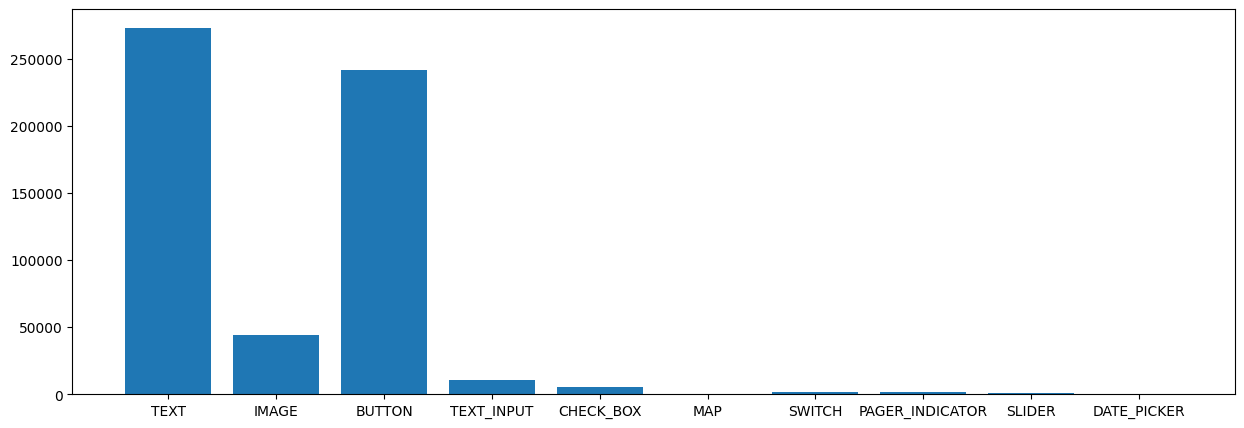

In [33]:
plt.figure(figsize=(15, 5))
plt.bar(*zip(*class_counter.items()))
plt.show()

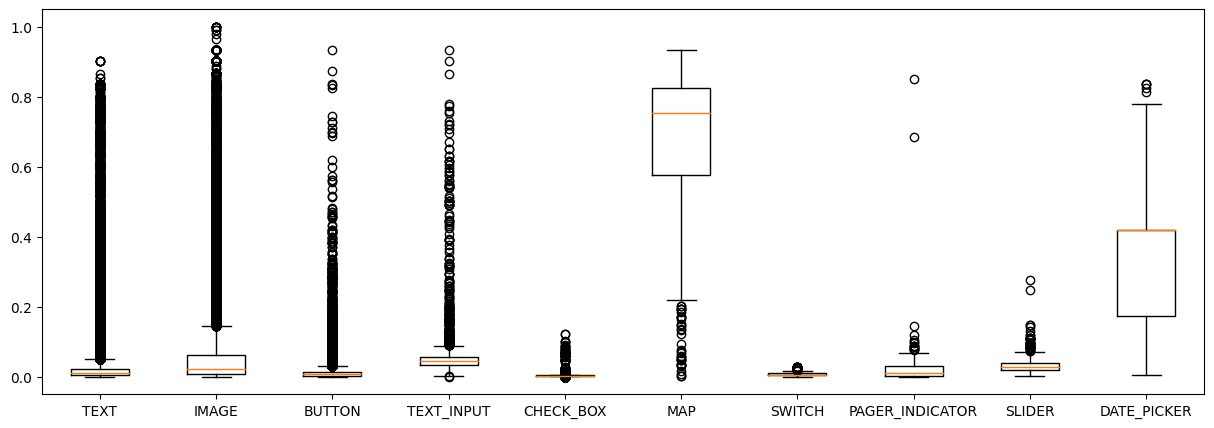

In [34]:
# Python 3.5+
plt.figure(figsize=(15, 5))
labels, data = [*zip(*class_square.items())]  # 'transpose' items to parallel key, value lists

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

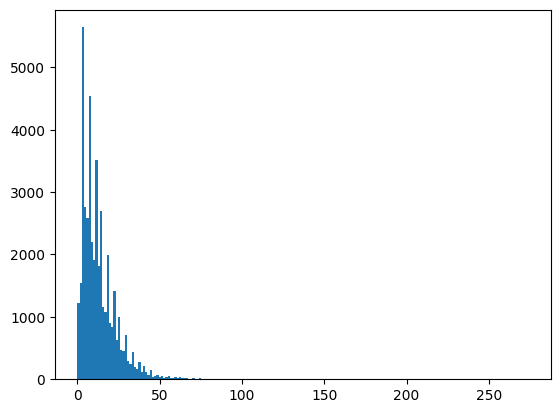

In [43]:
obj_per_img_vals = np.array(list(obj_per_image.values()))
plt.hist(obj_per_img_vals, bins = 200);

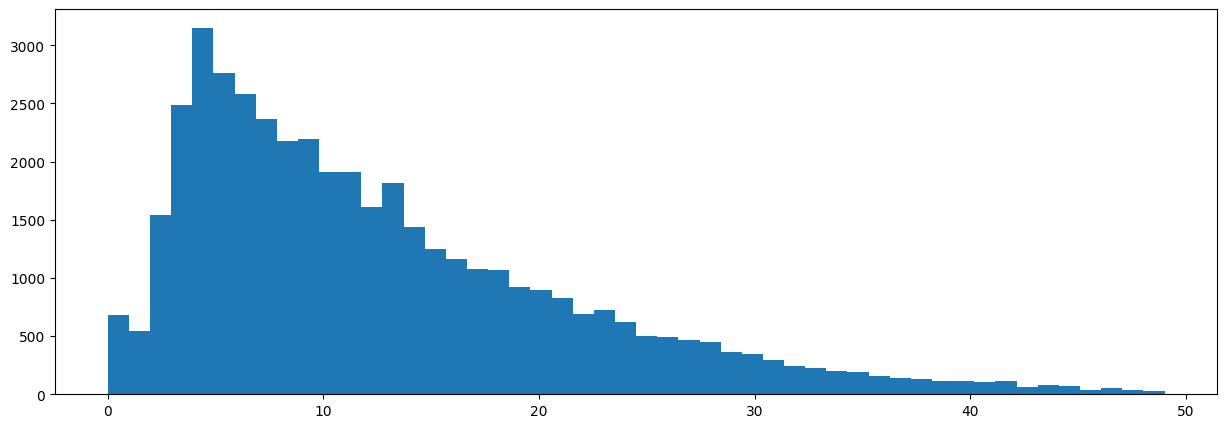

In [44]:
plt.figure(figsize=(15, 5))
plt.hist(obj_per_img_vals[obj_per_img_vals<50], bins = 50);


3. if button inside b'PAGER_INDICATOR -> button shoudl be removed
4. button inside button shoudl be fixed
5. text inside text shoudl be fixed
1. text inside button, I guess should be removed (2165)
4. just drop observation 28930, 35470, 12505, 7896


In [51]:
[i for i, v in enumerate(obj_per_img_vals) if v > 50]

[15,
 175,
 245,
 435,
 718,
 732,
 734,
 737,
 747,
 772,
 913,
 922,
 968,
 1142,
 1227,
 1300,
 1451,
 1711,
 2249,
 2251,
 2349,
 2417,
 2427,
 2428,
 2429,
 2438,
 2459,
 2500,
 2558,
 2854,
 2859,
 3163,
 3282,
 3283,
 3284,
 3288,
 3327,
 3328,
 3333,
 3334,
 3337,
 3338,
 3339,
 3340,
 3476,
 3839,
 3941,
 3954,
 3996,
 3997,
 4058,
 4200,
 4370,
 4604,
 4626,
 4841,
 4929,
 5523,
 5627,
 5638,
 5639,
 5640,
 5641,
 5727,
 5729,
 5836,
 5850,
 6265,
 6655,
 6701,
 6758,
 6759,
 6761,
 6762,
 6764,
 6787,
 6790,
 6798,
 7123,
 7194,
 7202,
 7203,
 7206,
 7229,
 7238,
 7241,
 7408,
 7420,
 7427,
 7507,
 7516,
 7725,
 7895,
 7896,
 7897,
 8844,
 8928,
 8981,
 9625,
 9841,
 9848,
 9854,
 9860,
 9886,
 9895,
 10099,
 10100,
 10118,
 10186,
 10248,
 10323,
 10587,
 10603,
 10645,
 10652,
 10653,
 10654,
 10659,
 10660,
 10661,
 10662,
 10728,
 10790,
 11005,
 11246,
 11295,
 11314,
 11316,
 11413,
 11665,
 11675,
 11867,
 11926,
 11983,
 12001,
 12310,
 12327,
 12350,
 12351,
 12352,

In [91]:
num_of_obs_to_find = 5
cnt = 0
for id_, raw_record in enumerate(raw_dataset.take(44000)):
    ex = tf.train.Example()
    ex.ParseFromString(raw_record.numpy())

    # parse recoed
    result = {}
    for key, feature in ex.features.feature.items():
      # The values are the Feature objects which contain a `kind` which contains:
      # one of three fields: bytes_list, float_list, int64_list

        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

    # fix record (delete/rename classes) and correct label
    ind_to_use = [idx for idx, val in enumerate(result['image/object/class/text']) if val.decode('UTF-8') not in LABELS_TO_DROP]
    updated_labels_text = [REPL_LABELS.get(i, i) for i in result['image/object/class/text'][ind_to_use]]
    updated_labels = [labels_codes[i.decode('UTF-8')] for i in updated_labels_text]

    # group PAGER_INDICATOR (just selex with max are, I assum that we have only 1 group of PAGER_INDICATOR)
    if 10 in updated_labels:
        if Counter(updated_labels)[10] >= 2:
            indicators = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'PAGER_INDICATOR']
            max_s = 0
            for ind, i in enumerate(indicators):
                w = result['image/object/bbox/xmax'][i] - result['image/object/bbox/xmin'][i]
                h = result['image/object/bbox/ymax'][i] - result['image/object/bbox/ymin'][i]
                curr_s = w * h
                #print(curr_s)
                if max_s <= curr_s:
                    max_s = curr_s
                    max_ind = i

            indicators.remove(max_ind)
            [ind_to_use.remove(i) for i in indicators]

    # drop too big SWITCH (it is mistakes in annotations
    if 3 in updated_labels:
        ind_of_switch = [ind for ind, i in enumerate(result['image/object/class/text']) if i == b'BUTTON']
        for ind in ind_of_switch:
            w = result['image/object/bbox/xmax'][ind] - result['image/object/bbox/xmin'][ind]
            h = result['image/object/bbox/ymax'][ind] - result['image/object/bbox/ymin'][ind]
            curr_s = w * h
            if (curr_s > 0.3):# & (curr_s< 0.4):
                print(id_)
                cnt += 1
                if cnt == 5: break

826
1975
7099
7099
9410
9415
9751
11384
11392
14032
14907
14907
14912
14912
16698
16698
18572
18644
21139
21150
21703
26774
26950
28607
28625
29241
29241
30448
31010
32502
32851
38039
42053
43355
43866


# temp

If we list all the natural numbers below 10 that are multiples of 3 or 5, we get 3, 5, 6 and 9. The sum of these multiples is 23.

Find the sum of all the multiples of 3 or 5 below 1000.

In [268]:
%%timeit -n 10

def is_multiplies(v, m):
    if v % m == 0:
        return True
    else:
        return False
    
mult_c = 0

for i in range(1000):
    if is_multiplies(i, 3) or is_multiplies(i, 5):
        mult_c += i
        
mult_c

294 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [267]:
%%timeit 

n = 1000

m = 3
N = int(n//m)

sum_3 = (N/2) * (2*m + (N - 1)* m)

m = 5
N = int(n//m)

sum_5 = (N/2) * (2*m + (N - 1)* m)

m = 15
N = int(n//m)

sum_15 = (N/2) * (2*m + (N - 1)* m)

sum_3 + sum_5 - sum_15

776 ns ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
